# Overwatch League Project

### Project Overview

The goal of this project is to derive meaningful insights from a dataset focused on eSports analytics.
<br> We want to assess each team's performance in a digestable format for both internal stakeholders and the League's public audience.
<br> The information will be presented in a comprehensive dashboard acting as a starting point for further analysis.

* The dashboard can be viewed here: [OWL 2018 Team-Specific Statistics](https://public.tableau.com/app/profile/anthony.boudreau/viz/OverwatchLeagueProject/OWL2018T-SStats)

* See [Filters & Metrics](#Dashboard-Details) section for additional details about the dashboard.

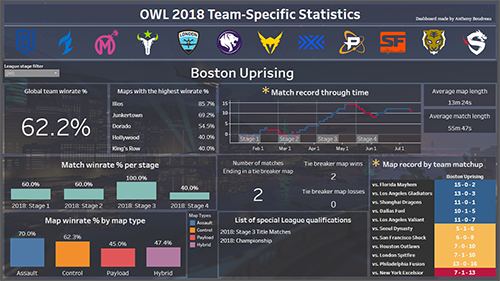
<br>

We will be using team & player statistics available on the 'Overwatch League Stats Lab' webpage.
<br> Link: https://overwatchleague.com/en-us/statslab

Since this project involves joining fields from several 'Player Stats' datasets, we will be limiting the project's scope to the 2018 League results.

For a better understanding of our data, we need to familiarize ourselves with the official rules of the League.
<br> We'll be referencing 2 documents throughout this project:

1. [Rules of Competition Summary for Season 2018](https://bnetcmsus-a.akamaihd.net/cms/content_entry_media/eo/EOC4AITZTVME1519148239333.pdf)
2. [Summary of Official Rules and Code of Conduct for Season 2020](https://bnetcmsus-a.akamaihd.net/cms/page_media/wg/WG2YO9KJ0I5I1587056527743.pdf)

\**Some rules relating to map rotations were omitted from the 2018 Summary, but included in the 2020 version.*

#### Important key terms

- Matches: Two competing teams play a series of four Maps against each other. The team with the most map wins are crowned the victor. Should both teams end the series with an equal amount of wins, a fifth map will be played and determine the winners. These rules may change during special League events, such as Championships.
<br><br>
- Maps (or games): Referring to a standard competitive Overwatch game. Certain map types, such as control points, are played on sub-maps, based on the main map's theme and world location. To reduce ambiguity, all Overwatch games will be referred to as 'maps'.
<br><br>
- Rounds: Each round, teams are placed on either the attacking or defending side of the map. For most map types, attackers must complete objectives while defenders prevent them from succceding. Once all objectives are completed or the timer runs out, both teams switch sides and run the game again. To win a map, one team must earn more objective points than the opposing team. Map draws occur when both teams run out of time with the same amount of objective points earned after at least 2 rounds.
<br><br>
- Rounds on control maps: Both teams have the same objective each round. Control the center of the map as long as possible. The best two out of three rounds win. Control maps cannot end in draws. 

### Step 1. Importing the 'Map Stats' dataset

In [1]:
# Importing numpy & pandas packages
import numpy as np
import pandas as pd

In [2]:
# Importing 'match_map_stats.csv'
map_stats = pd.read_csv('match_map_stats.csv')

# Ensure rounds are in chronological order
map_stats = map_stats.sort_values('round_start_time', ascending=True)

# Validate csv import
# First exploration of the dataset
print(map_stats.head())

  round_start_time  round_end_time          stage  match_id  game_number  \
0   01/11/18 00:12  01/11/18 00:20  2018: Stage 1     10223            1   
1   01/11/18 00:22  01/11/18 00:27  2018: Stage 1     10223            1   
2   01/11/18 00:34  01/11/18 00:38  2018: Stage 1     10223            2   
3   01/11/18 00:40  01/11/18 00:44  2018: Stage 1     10223            2   
4   01/11/18 00:46  01/11/18 00:49  2018: Stage 1     10223            2   

          match_winner           map_winner            map_loser  \
0  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   
1  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   
2  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   
3  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   
4  Los Angeles Valiant  Los Angeles Valiant  San Francisco Shock   

           map_name  map_round  ...        team_one_name        team_two_name  \
0            Dorado          1  ...  Los Angeles Vali

### Step 2. Limiting 'Map Stats' to Season 2018

As mentioned previously, we want to limit the scope of the project to 2018.
<br> To do so, we identify the year of the rounds played using 'round_start_time' and keep the entries meeting our criteria.

In [3]:
# Add a new field indicating the year of the 'round start' timestamp
map_stats['year'] = pd.DatetimeIndex(map_stats['round_start_time']).year

# Validate new field
print(map_stats[['round_start_time', 'year']].head())

  round_start_time  year
0   01/11/18 00:12  2018
1   01/11/18 00:22  2018
2   01/11/18 00:34  2018
3   01/11/18 00:40  2018
4   01/11/18 00:46  2018


In [4]:
# Limit entries to matches played in 2018
map_stats_2018 = map_stats[map_stats['year'] == 2018]

# Check the first and last chronological values of our dataframe
print(map_stats_2018[['round_start_time','stage']].head(-5))

     round_start_time               stage
0      01/11/18 00:12       2018: Stage 1
1      01/11/18 00:22       2018: Stage 1
2      01/11/18 00:34       2018: Stage 1
3      01/11/18 00:40       2018: Stage 1
4      01/11/18 00:46       2018: Stage 1
...               ...                 ...
2660   07/28/18 00:35  2018: Championship
2661   07/28/18 00:48  2018: Championship
2662   07/28/18 00:58  2018: Championship
2663   07/28/18 20:25  2018: Championship
2664   07/28/18 20:35  2018: Championship

[2665 rows x 2 columns]


We are left with rounds from 5 distinct stages:

- 2018: Stage 1 through 4
- 2018: Championship

### Step 3. Adding map types using 'Player Stats'

An obvious way to add map types to our dataframe would be to create a dictionary from a list of playable maps and associate each map to its respective map type. While this may be more convenient for this exercise, joining 'Player Stats' with the rest of our current dataframe gives us the ability to add player information at a later point. Since each 'Player Stats' dataset is split into stages, we combine the relevant ones from 2018 together.

In [5]:
# Create dataframes of 'Player Stats' from each stage
player_stats_s1 = pd.read_csv('phs_2018/phs_2018_stage_1.csv')
player_stats_s2 = pd.read_csv('phs_2018/phs_2018_stage_2.csv')
player_stats_s3 = pd.read_csv('phs_2018/phs_2018_stage_3.csv')
player_stats_s4 = pd.read_csv('phs_2018/phs_2018_stage_4.csv')
player_stats_po = pd.read_csv('phs_2018/phs_2018_playoffs.csv')

# First exploration of 'Player Stats'
print(player_stats_s1.head())

       start_time  match_id                       stage map_type map_name  \
0  1/11/2018 0:12     10223  Overwatch League - Stage 1  PAYLOAD   Dorado   
1  1/11/2018 0:12     10223  Overwatch League - Stage 1  PAYLOAD   Dorado   
2  1/11/2018 0:12     10223  Overwatch League - Stage 1  PAYLOAD   Dorado   
3  1/11/2018 0:12     10223  Overwatch League - Stage 1  PAYLOAD   Dorado   
4  1/11/2018 0:12     10223  Overwatch League - Stage 1  PAYLOAD   Dorado   

      player                 team             stat_name        hero  \
0  Agilities  Los Angeles Valiant       All Damage Done  All Heroes   
1  Agilities  Los Angeles Valiant               Assists  All Heroes   
2  Agilities  Los Angeles Valiant   Barrier Damage Done  All Heroes   
3  Agilities  Los Angeles Valiant  Damage - Quick Melee  All Heroes   
4  Agilities  Los Angeles Valiant                Deaths  All Heroes   

    stat_amount  
0  18079.206920  
1     17.000000  
2   2893.659185  
3    443.204010  
4     11.000000  


In [6]:
# 1. Check earliest & latest match timestamps from our dataframes
# 2. Inspect 'map_type' field
print(player_stats_s1[['start_time', 'match_id', 'map_type']].head()) # From 01/11/2018
print(player_stats_po[['start_time', 'match_id', 'map_type']].tail()) # To 07/28/2018

       start_time  match_id map_type
0  1/11/2018 0:12     10223  PAYLOAD
1  1/11/2018 0:12     10223  PAYLOAD
2  1/11/2018 0:12     10223  PAYLOAD
3  1/11/2018 0:12     10223  PAYLOAD
4  1/11/2018 0:12     10223  PAYLOAD
            start_time  match_id map_type
55251  7/28/2018 21:18     13134   HYBRID
55252  7/28/2018 21:18     13134   HYBRID
55253  7/28/2018 21:18     13134   HYBRID
55254  7/28/2018 21:18     13134   HYBRID
55255  7/28/2018 21:18     13134   HYBRID


In [7]:
# Union files together
player_stats_all = pd.concat([player_stats_s1, player_stats_s2, player_stats_s3, player_stats_s4, player_stats_po], ignore_index=True)

# Change 'map_type' capitalization
player_stats_all['map_type'] = player_stats_all['map_type'].str.capitalize()

# 1. Check first and last match timestamps from unioned file
# 2. Validate 'map_type' capitalization change
print(player_stats_all[['start_time', 'match_id', 'map_type']].head())
print(player_stats_all[['start_time', 'match_id', 'map_type']].tail())

       start_time  match_id map_type
0  1/11/2018 0:12     10223  Payload
1  1/11/2018 0:12     10223  Payload
2  1/11/2018 0:12     10223  Payload
3  1/11/2018 0:12     10223  Payload
4  1/11/2018 0:12     10223  Payload
              start_time  match_id map_type
1124413  7/28/2018 21:18     13134   Hybrid
1124414  7/28/2018 21:18     13134   Hybrid
1124415  7/28/2018 21:18     13134   Hybrid
1124416  7/28/2018 21:18     13134   Hybrid
1124417  7/28/2018 21:18     13134   Hybrid


Instead of performing a dodgy inner join between datasets, forcing a '1 to 1' relationship, we create a subset of 'Player Stats', matching the number of rows from 'Map Stats'.

We group data from each map played and rank each entry in chronological order.
<br> This acts as the 'map_round' field missing from 'Player Stats'.

To ensure that maps could not be played twice in a match, creating potential issues during the grouping process, we've consulted both rule books.
<br> While this information was omitted from the 2018 version, the 2020 rule book states:

* "No map may be played twice in any match." - Section 5.8 Season Playoffs (a) Play-in Tournament (v)
<br> We assume this holds true for 2018 as well.

With this information, we are certain that each round played acts as a unique 'map_round' identifier.

In [8]:
# Enumerate each data entry for every map played ('map_name') in every match ('match_id')
# Acts as 'round' key when joining data with 'map_stats_sorted_2018'
player_stats_all['map_round'] = player_stats_all.groupby(['match_id','map_name'])['match_id'].rank(method='first')

# Validate row enumeration
# We want to verify this enumeration resets properly

# The 2nd map played in the first match appears at row 786
print(player_stats_all.iloc[785:,:][['match_id', 'map_name', 'map_round']].head())

# The 2nd match appears at row 3604
print(player_stats_all.iloc[3603:,:][['match_id', 'map_name', 'map_round']].head())

# Convert float value to integer
player_stats_all['map_round'] = pd.to_numeric(player_stats_all['map_round'], downcast='integer')

# Validate data type change
print(player_stats_all[['match_id', 'map_name', 'map_round']].head())

     match_id          map_name  map_round
785     10223            Dorado      786.0
786     10223  Temple of Anubis        1.0
787     10223  Temple of Anubis        2.0
788     10223  Temple of Anubis        3.0
789     10223  Temple of Anubis        4.0
      match_id map_name  map_round
3603     10223  Numbani      866.0
3604     10224   Dorado        1.0
3605     10224   Dorado        2.0
3606     10224   Dorado        3.0
3607     10224   Dorado        4.0
   match_id map_name  map_round
0     10223   Dorado          1
1     10223   Dorado          2
2     10223   Dorado          3
3     10223   Dorado          4
4     10223   Dorado          5


In [9]:
# Left join 'Player Stats' on 'Map Stats'
# _wmt -> with 'map_type'
maps_stats_2018_wmt = pd.merge(map_stats_2018, player_stats_all[['match_id', 'map_name', 'map_round', 'map_type']], how='inner', on=['match_id', 'map_name', 'map_round'])

# Validating merge
print(maps_stats_2018_wmt.iloc[:, -4:].head())
print(len(maps_stats_2018_wmt.index)) # Counting entries for a '1 to 1' join relationship
print(len(maps_stats_2018_wmt.index) == len(map_stats_2018.index)) # Ensuring all entries were joined

   attacker_round_end_score  defender_round_end_score  year map_type
0                         2                         0  2018  Payload
1                         3                         2  2018  Payload
2                         2                         0  2018  Assault
3                         2                         2  2018  Assault
4                         4                         2  2018  Assault
2670
True


### Step 4. Modify 'Map Stats' data layout

Currently, each row indicates round results relating to both competing teams.
<br> This data layout makes it difficult to perform team aggregations. We need a more granular dataset.

To do so, we duplicate each row, assigning one per team, and adjust the table's field values to reflect team results rather than round results.

In [10]:
# Create new dataframe for 'team one'
# deep=True -> Modifications to the data or indices of the copy will not be reflected in the original object
maps_stats_2018_wmt_t1 = maps_stats_2018_wmt.copy(deep=True)

# Designate 'team one' as the dataframe's main row  
maps_stats_2018_wmt_t1['team_name'] = maps_stats_2018_wmt_t1['team_one_name']

# Create new dataframe for 'team two'
maps_stats_2018_wmt_t2 = maps_stats_2018_wmt.copy(deep=True)

# Designate 'team two' as the dataframe's main row
maps_stats_2018_wmt_t2['team_name'] = maps_stats_2018_wmt_t2['team_two_name']

# Union both new dataframes
# ignore_index=True -> To validate proper union, the index will alternate between dataframes when sorted
maps_stats_2018_wmt_team = pd.concat([maps_stats_2018_wmt_t1, maps_stats_2018_wmt_t2], ignore_index=True)

# Sort new table chronologically
maps_stats_2018_wmt_team = maps_stats_2018_wmt_team.sort_values(['round_start_time', 'team_one_name'], ascending=True)

# Validate union
print(len(maps_stats_2018_wmt.index)) # Check original number of rows
print(len(maps_stats_2018_wmt_team.index)) # Check new number of rows
print(maps_stats_2018_wmt_team.columns) # Check new 'team_name' field
print(maps_stats_2018_wmt_team[['round_start_time',
                                'match_id',
                                'game_number',
                                'map_round',
                                'team_name']].head()) # Check alternating indexes & team names

2670
5340
Index(['round_start_time', 'round_end_time', 'stage', 'match_id',
       'game_number', 'match_winner', 'map_winner', 'map_loser', 'map_name',
       'map_round', 'winning_team_final_map_score',
       'losing_team_final_map_score', 'control_round_name', 'Attacker',
       'Defender', 'team_one_name', 'team_two_name',
       'attacker_payload_distance', 'defender_payload_distance',
       'attacker_time_banked', 'defender_time_banked',
       'attacker_control_perecent', 'defender_control_perecent',
       'attacker_round_end_score', 'defender_round_end_score', 'year',
       'map_type', 'team_name'],
      dtype='object')
     round_start_time  match_id  game_number  map_round            team_name
0      01/11/18 00:12     10223            1          1  Los Angeles Valiant
2670   01/11/18 00:12     10223            1          1  San Francisco Shock
1      01/11/18 00:22     10223            1          2  Los Angeles Valiant
2671   01/11/18 00:22     10223            1       

#### Validation results
1. Check original & new row numbers: As intended, the number of entries has doubled. Indicating that both dataframes were joined.
2. Check new 'team_name' field: As intended, a new field has been added at the end of the new dataframe titled 'team_name'.
3. Check alternating indexes & team names: Sorting the new dataframe chronologically places each row of the 'team two' dataframe under its respective 'team one' counterpart.

In [11]:
# Reset dataframe index
map_stats_v2 = maps_stats_2018_wmt_team.reset_index(drop=True)

# Validate reset
print(map_stats_v2[['round_start_time',
                    'match_id',
                    'game_number',
                    'map_round',
                    'team_name']].head())

  round_start_time  match_id  game_number  map_round            team_name
0   01/11/18 00:12     10223            1          1  Los Angeles Valiant
1   01/11/18 00:12     10223            1          1  San Francisco Shock
2   01/11/18 00:22     10223            1          2  Los Angeles Valiant
3   01/11/18 00:22     10223            1          2  San Francisco Shock
4   01/11/18 00:34     10223            2          1  Los Angeles Valiant


### Step 5. 'Maps Stats' field manipulation

#### Step 5.1 Adding a match date field

The exact time at which matches occur aren't relevant for our analysis. We're simply interested in having a date reference for each match played.
<br> Should a match's time interval overlap two consecutive days, i.e., matches starting on one day and ending on the next, we only consider the starting date.

In [12]:
# Add new field indicating the start datetime of a match
map_stats_v2['min_round_start_time'] = map_stats_v2.groupby('match_id')['round_start_time'].transform('min')

# Validate new field

# Check the constancy of the first few values
print(map_stats_v2[['match_id', 'game_number', 'map_round', 'min_round_start_time', 'round_start_time']].head())

# The 2nd match appears at row 22
print(map_stats_v2.iloc[21:,:][['match_id',
                                'game_number',
                                'map_round',
                                'min_round_start_time',
                                'round_start_time']].head())

   match_id  game_number  map_round min_round_start_time round_start_time
0     10223            1          1       01/11/18 00:12   01/11/18 00:12
1     10223            1          1       01/11/18 00:12   01/11/18 00:12
2     10223            1          2       01/11/18 00:12   01/11/18 00:22
3     10223            1          2       01/11/18 00:12   01/11/18 00:22
4     10223            2          1       01/11/18 00:12   01/11/18 00:34
    match_id  game_number  map_round min_round_start_time round_start_time
21     10223            4          3       01/11/18 00:12   01/11/18 01:41
22     10224            1          1       01/11/18 02:08   01/11/18 02:08
23     10224            1          1       01/11/18 02:08   01/11/18 02:08
24     10224            1          2       01/11/18 02:08   01/11/18 02:15
25     10224            1          2       01/11/18 02:08   01/11/18 02:15


In [13]:
# Add new field
# Convert datetime value of 'min_round_start_time' to a date only
map_stats_v2['date'] = pd.to_datetime(map_stats_v2['min_round_start_time']).dt.date

# Validate new field
# The 2nd day of matches appears at row 124
print(map_stats_v2.iloc[123:,:][['match_id',
                                 'game_number',
                                 'min_round_start_time',
                                 'round_start_time',
                                 'date']].head())

     match_id  game_number min_round_start_time round_start_time        date
123     10228            4       01/12/18 01:59   01/12/18 03:22  2018-01-12
124     10229            1       01/13/18 00:10   01/13/18 00:10  2018-01-13
125     10229            1       01/13/18 00:10   01/13/18 00:10  2018-01-13
126     10229            1       01/13/18 00:10   01/13/18 00:19  2018-01-13
127     10229            1       01/13/18 00:10   01/13/18 00:19  2018-01-13


#### Step 5.2 Adding match & map length fields

We would also like to know how long matches and map games lasted.

Using 'round_start_time' & 'round_end_time', we approximate these results using the sum of round lengths.

In [14]:
# Check 'round_start_time' & 'round_end_time' data types
print(map_stats_v2[['round_start_time','round_end_time']].dtypes)

# Dataframe objects cannot be used in datetime calculations

# Convert 'round_start_time' to a datetime data type
# infer_datetime_format=True -> Attempt to infer the format of the datetime strings
map_stats_v2['round_start_time_dt'] = pd.to_datetime(map_stats_v2['round_start_time'], infer_datetime_format=True)

# Convert 'round_end_time' to a datetime data type
map_stats_v2['round_end_time_dt'] = pd.to_datetime(map_stats_v2['round_end_time'], infer_datetime_format=True)

# Subsctract 'round_end_time_dt' by 'round_start_time_dt'
# Return round length in seconds
map_stats_v2['round_length_sec'] = (map_stats_v2['round_end_time_dt'] - map_stats_v2['round_start_time_dt']).dt.total_seconds()

# Validate new fields and their data types
print(map_stats_v2.iloc[:,-4:].dtypes)
print(map_stats_v2.iloc[:,-4:].head())

round_start_time    object
round_end_time      object
dtype: object
date                           object
round_start_time_dt    datetime64[ns]
round_end_time_dt      datetime64[ns]
round_length_sec              float64
dtype: object
         date round_start_time_dt   round_end_time_dt  round_length_sec
0  2018-01-11 2018-01-11 00:12:00 2018-01-11 00:20:00             480.0
1  2018-01-11 2018-01-11 00:12:00 2018-01-11 00:20:00             480.0
2  2018-01-11 2018-01-11 00:22:00 2018-01-11 00:27:00             300.0
3  2018-01-11 2018-01-11 00:22:00 2018-01-11 00:27:00             300.0
4  2018-01-11 2018-01-11 00:34:00 2018-01-11 00:38:00             240.0


In [15]:
# Sum round lengths for each map, i.e., for each 'match_id' + 'game_number'
map_stats_v2['game_length_sec'] = map_stats_v2.groupby(['match_id', 'game_number', 'team_name'])['round_length_sec'].transform('sum')

# Sum round lengths for each match, i.e., for each 'match_id'
map_stats_v2['match_length_sec'] = map_stats_v2.groupby(['match_id', 'team_name'])['round_length_sec'].transform('sum')


# Validate new column values from 1 match of 1 team
# 'match_id' = 10223
# 'team_name' = 'Los Angeles Valiant'

# Validate 'game_length_sec' field
print(map_stats_v2[(map_stats_v2['team_name'] == 'Los Angeles Valiant') & (map_stats_v2['match_id'] == 10223)][['match_id', 'game_number', 'game_length_sec', 'map_round', 'round_length_sec']])

# Validate 'match_length_sec' field
print(map_stats_v2[(map_stats_v2['team_name'] == 'Los Angeles Valiant') & (map_stats_v2['match_id'] == 10223)][['match_id', 'match_length_sec', 'game_number', 'game_length_sec']])

    match_id  game_number  game_length_sec  map_round  round_length_sec
0      10223            1            780.0          1             480.0
2      10223            1            780.0          2             300.0
4      10223            2            960.0          1             240.0
6      10223            2            960.0          2             240.0
8      10223            2            960.0          3             180.0
10     10223            2            960.0          4             300.0
12     10223            3            780.0          1             300.0
14     10223            3            780.0          2             180.0
16     10223            3            780.0          3             300.0
18     10223            4            660.0          1             420.0
20     10223            4            660.0          3             240.0
    match_id  match_length_sec  game_number  game_length_sec
0      10223            3180.0            1            780.0
2      10223  

- The rounds lasted between 3 min. (180 sec.) and 8 min. (480 sec.)
    - 'game_length_sec' values equate to the sum of the corresponding 'round_length_sec' fields.
<br><br>
- The match itself lasted approximately 53 min. (3180 sec.) with 4 maps played, ranging between 11 min. (660 sec.) and 16 min. (960 sec.)
    - 'match_length_sec' values equate to the sum of the corresponding 'game_length_sec' fields.

#### Step 5.3 Modify existing fields to the reflect new data layout

Entries now designate round results for specific teams. The field names and their corresponding values should reflect this change.

These changes include the following:
1. A designated field for the opposing team, regardless of the outcome.
2. A single field indicating the team's side, i.e., attacking or defending.
3. Round scores only related to an entry's designated team.
4. Outcome fields returning an outcome result instead of a team name.

In [16]:
# 1. A designated field for the opposing team, regardless of the outcome.

# IF condition where the 'opposing_team_name' must not be the 'team_name' found in either 'team_one_name' or 'team_two_name'.
map_stats_v2['opposing_team_name'] = np.where(map_stats_v2['team_name'] == map_stats_v2['team_one_name'],
                                              map_stats_v2['team_two_name'],
                                              map_stats_v2['team_one_name'])

# Validate new column
print(map_stats_v2[['match_id', 'map_round', 'team_name', 'opposing_team_name']].head())

   match_id  map_round            team_name   opposing_team_name
0     10223          1  Los Angeles Valiant  San Francisco Shock
1     10223          1  San Francisco Shock  Los Angeles Valiant
2     10223          2  Los Angeles Valiant  San Francisco Shock
3     10223          2  San Francisco Shock  Los Angeles Valiant
4     10223          1  Los Angeles Valiant  San Francisco Shock


In [17]:
# 2. A single field indicating the team's side, i.e., attacking or defending.

# IF condition indicating the side of map the team is playing on.
map_stats_v2['map_side'] = np.where(map_stats_v2['team_name'] == map_stats_v2['Attacker'],
                                    'Attacker',
                                    'Defender')

# Validate new column
print(map_stats_v2[['match_id', 'map_round', 'team_name', 'map_side', 'Attacker']].head())

   match_id  map_round            team_name  map_side             Attacker
0     10223          1  Los Angeles Valiant  Defender  San Francisco Shock
1     10223          1  San Francisco Shock  Attacker  San Francisco Shock
2     10223          2  Los Angeles Valiant  Attacker  Los Angeles Valiant
3     10223          2  San Francisco Shock  Defender  Los Angeles Valiant
4     10223          1  Los Angeles Valiant  Defender  San Francisco Shock


In [18]:
# 3. Round scores only relating to an entry's designated team.

# IF condition indicating the round end score of the designated team.
# *All '_end_score' fields indicate the cumulative score of a given game after each round.
map_stats_v2['round_end_score'] = np.where(map_stats_v2['team_name'] == map_stats_v2['Attacker'],
                                           map_stats_v2['attacker_round_end_score'],
                                           map_stats_v2['defender_round_end_score'])

# Validate new column
print(map_stats_v2[['match_id', 'map_round', 'team_name', 'map_side', 'round_end_score']].head())

   match_id  map_round            team_name  map_side  round_end_score
0     10223          1  Los Angeles Valiant  Defender                0
1     10223          1  San Francisco Shock  Attacker                2
2     10223          2  Los Angeles Valiant  Attacker                3
3     10223          2  San Francisco Shock  Defender                2
4     10223          1  Los Angeles Valiant  Defender                0


In [19]:
# 4. Outcome fields returning an outcome result instead of a team name.

# New field indicating the match outcome for 'team_name'
# Binary outcome. No draws possible.
map_stats_v2['match_outcome'] = np.where(map_stats_v2['team_name'] == map_stats_v2['match_winner'], 'Win', 'Lose')

# New field indicating the map outcome for 'team_name'
# Ternary outcome.
map_stats_v2.loc[map_stats_v2['map_winner'] == map_stats_v2['team_name'], 'map_outcome'] = 'Win'
map_stats_v2.loc[map_stats_v2['map_winner'] == 'draw', 'map_outcome'] = 'Draw'
map_stats_v2.loc[map_stats_v2['map_winner'] == map_stats_v2['opposing_team_name'], 'map_outcome'] = 'Lose'

# Validate new column
print(map_stats_v2[['team_name',
                    'map_name',
                    'map_round',
                    'round_end_score']].head())

             team_name          map_name  map_round  round_end_score
0  Los Angeles Valiant            Dorado          1                0
1  San Francisco Shock            Dorado          1                2
2  Los Angeles Valiant            Dorado          2                3
3  San Francisco Shock            Dorado          2                2
4  Los Angeles Valiant  Temple of Anubis          1                0


### Step 6. Clean dataframe & field reordering

The last step is removing redundant or unecessary fields and ordering the remainder in a logical manner.
<br> This facilitates data exploration for end-users and other analysts.

In [20]:
# View all table columns
print(map_stats_v2.columns)

Index(['round_start_time', 'round_end_time', 'stage', 'match_id',
       'game_number', 'match_winner', 'map_winner', 'map_loser', 'map_name',
       'map_round', 'winning_team_final_map_score',
       'losing_team_final_map_score', 'control_round_name', 'Attacker',
       'Defender', 'team_one_name', 'team_two_name',
       'attacker_payload_distance', 'defender_payload_distance',
       'attacker_time_banked', 'defender_time_banked',
       'attacker_control_perecent', 'defender_control_perecent',
       'attacker_round_end_score', 'defender_round_end_score', 'year',
       'map_type', 'team_name', 'min_round_start_time', 'date',
       'round_start_time_dt', 'round_end_time_dt', 'round_length_sec',
       'game_length_sec', 'match_length_sec', 'opposing_team_name', 'map_side',
       'round_end_score', 'match_outcome', 'map_outcome'],
      dtype='object')


1. For this analysis, we aren't examining in-game performances. Therefore, any fields related to objective distances and percentages are removed.
<br>
2. Certain fields used to calculate length values are removed.
<br>
3. Outcome fields featured in the original data layout have been replaced by team-specific outcome fields.

In [21]:
map_stats_v2_trim = map_stats_v2.drop(['round_start_time', # Used in round length calculations
                                  'round_end_time', # Used in round length calculations
                                  'match_winner', # Replaced by 'match_outcome'
                                  'map_winner', # Replaced by 'map_outcome'
                                  'map_loser', # Replaced by 'map_outcome'
                                  'winning_team_final_map_score', # Not needed for analysis
                                  'losing_team_final_map_score', # Not needed for analysis
                                  'Attacker', # Replaced by 'map_side'
                                  'Defender', # Replaced by 'map_side'
                                  'team_one_name', # Used to designate 'team_name' & 'opposing_team_name'
                                  'team_two_name', # Used to designate 'team_name' & 'opposing_team_name'
                                  'attacker_payload_distance', # Not needed for analysis
                                  'defender_payload_distance', # Not needed for analysis
                                  'attacker_time_banked', # Not needed for analysis
                                  'defender_time_banked', # Not needed for analysis
                                  'attacker_control_perecent', # Not needed for analysis
                                  'defender_control_perecent', # Not needed for analysis
                                  'attacker_round_end_score', # Not needed for analysis
                                  'defender_round_end_score', # Not needed for analysis
                                  'min_round_start_time', # Replaced by 'date'
                                  'round_start_time_dt', # Used in round length calculations
                                  'round_end_time_dt', # Used in round length calculations
                                  'year'], # Used to trim dataset. See step 2.
                                           axis=1)

print(map_stats_v2_trim.columns)

Index(['stage', 'match_id', 'game_number', 'map_name', 'map_round',
       'control_round_name', 'map_type', 'team_name', 'date',
       'round_length_sec', 'game_length_sec', 'match_length_sec',
       'opposing_team_name', 'map_side', 'round_end_score', 'match_outcome',
       'map_outcome'],
      dtype='object')


In [22]:
# Reorder table fields
map_stats_final = map_stats_v2_trim[['date',
                                     'stage',
                                     'team_name',
                                     'opposing_team_name',
                                     'match_id',
                                     'match_outcome',
                                     'match_length_sec',
                                     'game_number',
                                     'game_length_sec',
                                     'map_name',
                                     'control_round_name',
                                     'map_type',
                                     'map_outcome',
                                     'map_round',
                                     'map_side',
                                     'round_length_sec',
                                     'round_end_score']]

# Validate new field ordering
print(map_stats_final.columns)

Index(['date', 'stage', 'team_name', 'opposing_team_name', 'match_id',
       'match_outcome', 'match_length_sec', 'game_number', 'game_length_sec',
       'map_name', 'control_round_name', 'map_type', 'map_outcome',
       'map_round', 'map_side', 'round_length_sec', 'round_end_score'],
      dtype='object')


### Step 7. Export the final version of the 'Map Stats' dataset

The final dataframe is converted back into a comma-seperated dataset, ready to be used in Tableau as its main data source.

In [23]:
# Final dataframe -> File used as data source in Tableau
map_stats_final.to_csv('map_stats_final.csv', index=False)

---

## Dashboard Details

### Filters & Metrics

[Return to Project Overview](#Overwatch-League-Project)

#### Filters

<!-- [Team]: Selecting one of the team icons at the top of the dashboard filters results by team.
[Stage]: Drop-down list of the four stages during the 2018 season. Stage selections include stage matches and title matches specific to the stage number.
[Stage- Details]: Championship results can only be viewed when clearing the filter. -->

|Name | Description | Selection Type | Special details |
|:--  | :--         | :--            | :--             |
| Team  | Selecting one of the team icons at the top of the dashboard filters results by team. | Single-select only          |                  |
| Stage | Drop-down list of the four stages during the 2018 season. Stage selections include stage matches and title matches specific to the stage number. | Multiple selections enabled | Championship results can only be viewed when clearing the filter. |

#### Metrics

<!-- [Match winrate per stage]: 
[Map winrate by map type]: 
[Match record through Time]: 
[Average map length]: 
[Average match length]: 
[Tiebreakers - Number of matches]: 
[Tiebreakers - Number of wins]: 
[Tiebreakers - Number of losses]: 
[List of special League qualifications]: 
[Map record by team matchup]:  -->

| Name | Result format | Tooltip Enabled? |
| :--  | :--           | :--              |
|Global team winrate                   | Percentage | No  |
|Top 5 highest map winrates            | Percentage | No  |
|Match winrate per stage               | Percentage | Yes |
|Map winrate by map type               | Percentage | Yes |
|Match record through Time             | Line chart | Yes |
|Average map length                    | Numerical  | No  |
|Average match length                  | Numerical  | No  |
|Tiebreakers - Number of matches       | Numerical  | No  |
|Tiebreakers - Number of wins          | Numerical  | No  |
|Tiebreakers - Number of losses        | Numerical  | No  |
|List of special League qualifications | Numerical  | No  |
|Map record by team matchup            | Numerical  | Yes |



## Thank you

Creating this dashboard has been a wonderful learning experience.
<br> I want to thank [Datacamp](https://www.datacamp.com/)'s staff and instructors for the comprehensive Python courses.

I am happy to answer any questions via email.
<br> Email: <mail.saboudreau@gmail.com>

Cheers!

- Anthony Boudreau

**~ Heroes Never Die ~**